In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display_html, display_markdown
import time

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [8]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Regression Model Comparison Template** 
This Notebook compares the performance of different types of regression models on a dataset provided by the user. It is meant to assist in the model selection process, helping users discern the most suitible regression technique for their dataset. Users should store data in the data directory.
### **Regression Analysis**
Regression refers to statistical methods for analyzing the relationship between dependent and independent variables. In machine learning, regression analysis is implimented as supervised learning algorithms used to identify the relationships between dependent variables called targets and predictive independent variables called features. Understanding this relationship 

In this example, the regression models are evaluated on a real world dataset on California housing. 

In [9]:
california_housing = fetch_california_housing(as_frame = True)
md(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surprisingly large values for block groups with few households
and many empty houses, such as vacation resorts.

It can be downloaded/loaded using the
:func:`sklearn.datasets.fetch_california_housing` function.

.. topic:: References

    - Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
      Statistics and Probability Letters, 33 (1997) 291-297


In [10]:
DATA_FILE_NAME: str = "" 
TARGET_COLUMN_NAME: str = ""
TARGET_VARIABLE_NAME: str = "MedHouseVal"
NUM_DECIMAL_PLACES: int = 5
TABLE_FONT_SIZE: int = 16 #px

## Loading in a Dataset and Handling Missing Values

In [11]:
def load_data(file_name: str = DATA_FILE_NAME, target_column_name: str = TARGET_COLUMN_NAME) -> tuple:
    """
    Loads in user's input file as a pandas DataFrame and cleans the data by dropping duplicate rows and removing rows with any missing values.
    
     Args:
        file_name (str): Name of file containing data for training and testing the models
        target_column_name (str): Name of the column containing your dataset's target variable
    Returns:
        tuple: Tuple contains a dataframe with feature data entries and a series with ccorresponding target entries
    """
    # Add df editing interface for dropping unwanted columns
    
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format. Please upload a CSV, Excel, or JSON file.")
    
    df.drop_duplicates(inplace = True)

    
    clean_feature_values_df = dropped_df.drop(columns = target_column_name)
    clean_target_values_series = dropped_df[target_column_name]
    return (clean_feature_values_df, clean_target_values_series, df)

feature_values_df, target_values_series, data_df = load_data()
feature_values_df.head()

In [12]:
feature_values_df = california_housing.data
target_values_series = california_housing.target

clean_features_df = feature_values_df.drop_duplicates()
clean_features_df.dropna(inplace = True)
clean_targets_df = target_values_series

In [13]:
FEATURE_LIST = list(feature_values_df.columns)
NUM_FEATURES = len(FEATURE_LIST)

## **Encoding Categorical Features**

In [ ]:
numerical_columns = list(data_df.select_dtypes(include = np.number).columns)
print(f"Numerical Features: {numerical_columns}")

categorical_columns = list(data_df.select_dtypes(exclude = np.number).columns)
print(f"Categorical Features: {categorical_columns}")
print()

for column in categorical_columns:
    print(f"{column} Column Unique Entries: {data_df.dropna()[column].unique()}")
    print()

data_df.head()

In [86]:
nominal_categorical_column_names: list[str] = []
ordinal_categorical_column_names: list[str] = []
ordianl_categories_ordered_list: list[list[str]] = [[]]
numerical_colums_to_scale: list[str] = numerical_columns
onehot_drop_column = "first"

X_train, X_test, y_train, y_test = train_test_split(dropna_X, dropna_y, test_size = 0.2, random_state = 42)

general_feature_preprocessor = ColumnTransformer(
    transformers = [
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_column_names),
        ('scaler', StandardScaler(), numerical_colums_to_scale)
    ]
)
nominal_target_preprocessor = LabelEncoder()

y_train = nominal_target_preprocessor.fit_transform(y_train)
y_test = nominal_target_preprocessor.fit_transform(y_test)

## **Data Preprocessing and Model Training**


In [15]:
alpha_values = np.linspace(0.01, 100, num = 100)

models = {
    'Linear': {
        'model': make_pipeline(StandardScaler(), LinearRegression()),
        'param_grid': {}  
    },
    'Lasso': {
        'model': make_pipeline(StandardScaler(), Lasso()),
        'param_grid': {'lasso__alpha': alpha_values}
    },
    'Ridge': {
        'model': make_pipeline(StandardScaler(), Ridge()),
        'param_grid': {'ridge__alpha': alpha_values}
    },
    'Random Forest': {
        "model_type": Ridge,
        'model': RandomForestRegressor(random_state = 42), 
        'param_grid': {
            'n_estimators': [100, 200],  
            'max_depth': [None, 20],  
            'max_features': [1.0, "sqrt"]
        }
    },
    'SVR': { 
        "model_type": Ridge,
        'model': make_pipeline(StandardScaler(), SVR()),
        'param_grid': {
            'svr__C': [.1, 1, 10]  
        }
    }
}

X_train, X_test, y_train, y_test = train_test_split(clean_features_df, clean_targets_df, test_size = 0.2, random_state = 42)
results = {}
result_df_data = []

for model_name, model_data in models.items():
    print(f"Training and evaluating: {model_name}") 

    model = model_data['model']
    param_grid = model_data['param_grid']
    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    grid_search = GridSearchCV(model, param_grid, cv = kf, scoring = 'neg_mean_squared_error')
    
    tune_train_start_time = time.time()
    grid_search.fit(X_train, y_train)
    tune_train_end_time = time.time()
    tune_train_time = tune_train_end_time - tune_train_start_time
    print(f"    Hyperparameter Tuning and Model Training Time: {tune_train_time:.2f} seconds")
    
    best_model = grid_search.best_estimator_
    
    results[model_name] = {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        "cv_results": grid_search.cv_results_,
        "tune_train_time": tune_train_time
    }
    
    y_train_prediction = best_model.predict(X_train)
    y_test_prediction = best_model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_prediction)
    test_mse = mean_squared_error(y_test, y_test_prediction) 
    test_mae = mean_absolute_error(y_test, y_test_prediction)
    test_r2 = r2_score(y_test, y_test_prediction)
    num_test_entries = len(y_test)
    test_adjusted_r2 = 1 - ((1 - test_r2) * (num_test_entries - 1) / (num_test_entries - NUM_FEATURES - 1))
    
    results[model_name]["y_train_prediction"] = y_train_prediction
    results[model_name]["y_test_prediction"] = y_test_prediction
    results[model_name]["train_mse"] = train_mse
    results[model_name]["test_mse"] = test_mse
    results[model_name]["test_mae"] = test_mae
    results[model_name]["test_r2"] = test_r2
    results[model_name]["test_adjusted_r2"] = test_adjusted_r2
    
    result_df_data.append([model_name, train_mse, test_mse, test_mae, test_r2, test_adjusted_r2])
    
    if model_name in ['Linear', 'Lasso', 'Ridge']:
        results[model_name]["intercept"] = best_model[-1].intercept_
        results[model_name]["coefficients"] = best_model[-1].coef_
    
    print()
    


Training and evaluating: Linear
    Hyperparameter Tuning and Model Training Time: 0.09 seconds

Training and evaluating: Lasso
    Hyperparameter Tuning and Model Training Time: 4.21 seconds

Training and evaluating: Ridge
    Hyperparameter Tuning and Model Training Time: 3.83 seconds

Training and evaluating: Random Forest
    Hyperparameter Tuning and Model Training Time: 272.46 seconds

Training and evaluating: SVR
    Hyperparameter Tuning and Model Training Time: 67.93 seconds



### **Functions for Displaying Data**

In [16]:
def create_fit_function_equation_markdown(intercept: int, coefficient_list: list, feature_list: list = FEATURE_LIST, num_decimal_places: int = NUM_DECIMAL_PLACES) -> str:
    model_equation = f"#### {TARGET_VARIABLE_NAME} = {intercept:.{num_decimal_places}f}"
    for i in range(len(coefficient_list)):
        model_equation += f" + {coefficient_list[i]:.{num_decimal_places}f}({feature_list[i]})"
    return model_equation

train_mse_string = "Mean Squared Error on Training Set"
mse_string = "Mean Squared Error on Testing Set"
mae_string = "Mean Absolute Error on Testing Set"
r2_string = "R-Squared Score on Testing Set"
adjusted_r2_string = "Adjusted R-Squared Score on Testing Set"


## **Individual Model Evaluation and Performance Visualizations**
#### **Linear Model**

In [88]:
linear_y_train_prediction = results["Linear"]["y_train_prediction"]
linear_y_test_prediction = results["Linear"]["y_test_prediction"]

linear_train_mse = results["Linear"]["train_mse"]
linear_test_mse = results["Linear"]["test_mse"]
linear_test_mae = results["Linear"]["test_mae"]
linear_test_r2 = results["Linear"]["test_r2"]
linear_test_adjusted_r2 = results["Linear"]["test_adjusted_r2"]

linear_intercept = results["Linear"]["intercept"]
linear_coefficients = results["Linear"]["coefficients"]

In [89]:

linear_equation = create_fit_function_equation_markdown(linear_intercept, linear_coefficients)

linear_train_mse_string = f"{train_mse_string}: {linear_train_mse}"
linear_mse_string = f"{mae_string}: {linear_test_mse}"
linear_mae_string = f"{mse_string}: {linear_test_mae}"
linear_r2_string = f"{r2_string}: {linear_test_r2}"
linear_adjusted_r2_string = f"{adjusted_r2_string}: {linear_test_adjusted_r2}"

linear_best_hyperparameters = results["Linear"]["best_params"]
print(f"Best Hyperparameter Combination: {linear_best_hyperparameters}")
print()
print("Model Equation:")
print(linear_equation)
print()
print(linear_train_mse_string)
print(linear_mse_string)
print(linear_mae_string)
print(linear_r2_string)
print(linear_adjusted_r2_string)

Model Equation:
MedHouseVal = 2.07195 + 0.85438(MedInc) + 0.12255(HouseAge) + -0.29441(AveRooms) + 0.33926(AveBedrms) + -0.00231(Population) + -0.04083(AveOccup) + -0.89693(Latitude) + -0.86984(Longitude)

Mean Squared Error on Training Set: 0.5179331255246699
Mean Absolute Error on Testing Set: 0.5558915986952442
Mean Squared Error on Testing Set: 0.5332001304956562
R-Squared Score on Testing Set: 0.575787706032451
Adjusted R-Squared Score on Testing Set: 0.574963792861356


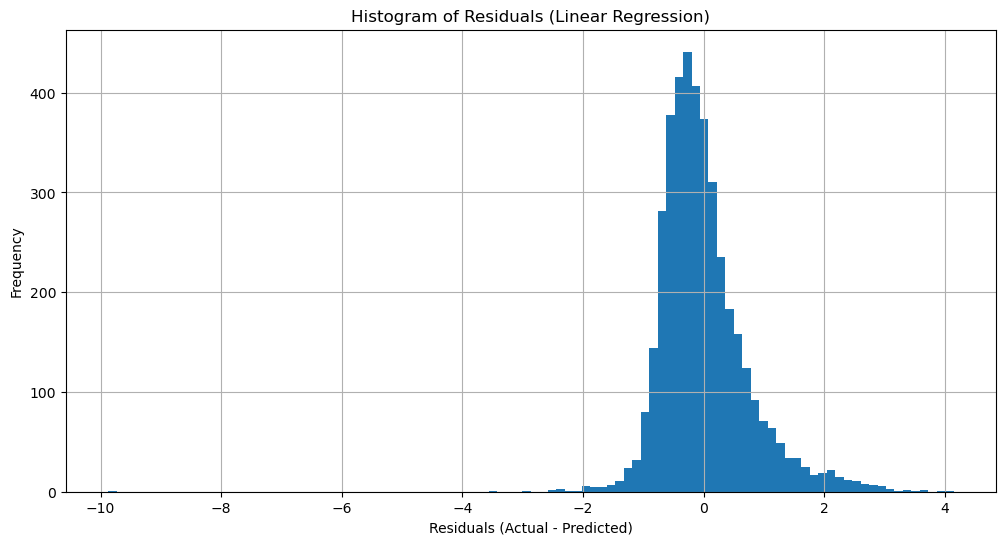

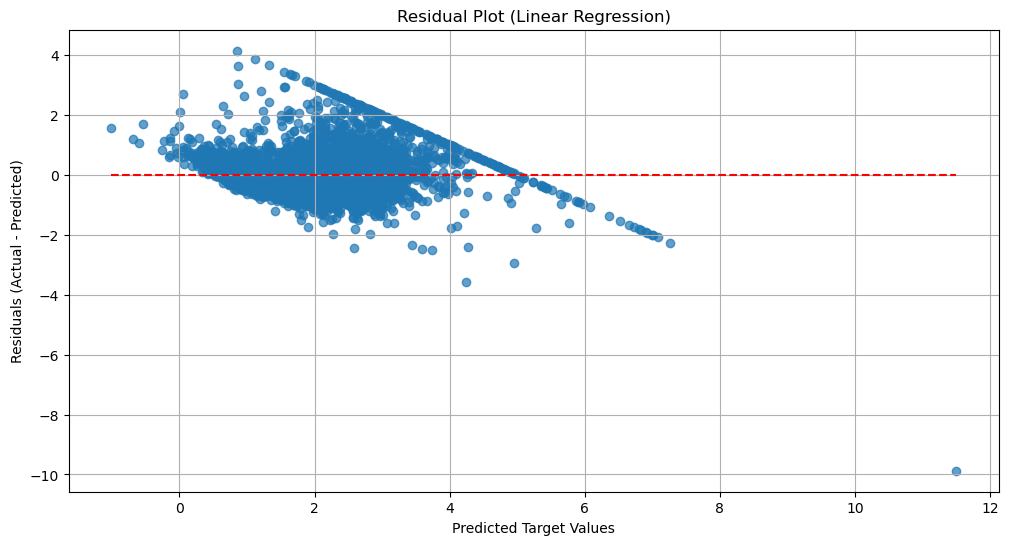

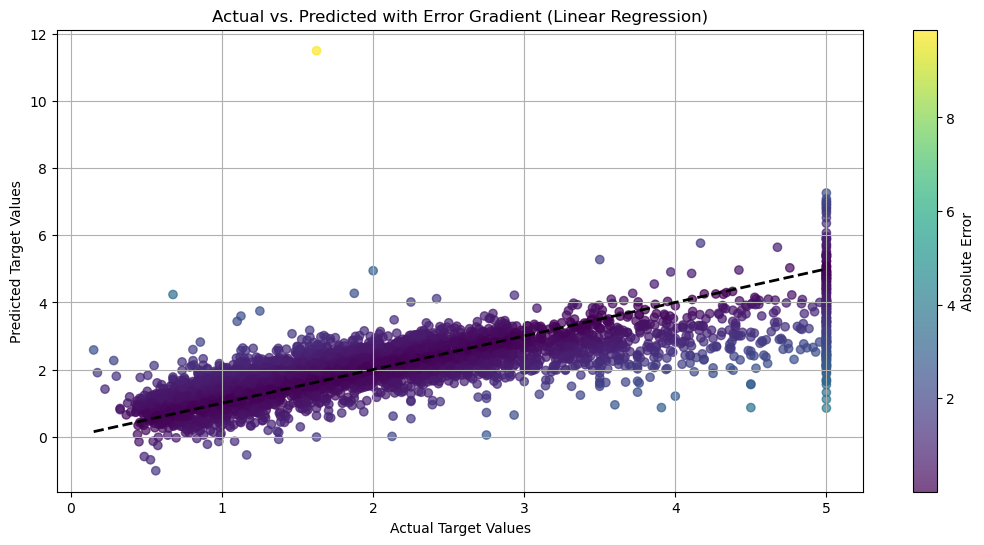

In [90]:
linear_residuals = y_test - linear_y_test_prediction

plt.figure(figsize = (12, 6))
plt.hist(linear_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(linear_y_test_prediction, linear_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = linear_y_test_prediction.min(), xmax = linear_y_test_prediction.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Linear Regression)')
plt.grid(True)
plt.show()

errors = abs(y_test - linear_y_test_prediction) 
plt.figure(figsize = (13, 6))
plt.scatter(y_test, linear_y_test_prediction, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Linear Regression)')
plt.grid(True)
plt.show()

#### **Lasso Model**

In [91]:
lasso_y_train_prediction = results["Lasso"]["y_train_prediction"]
lasso_y_test_prediction = results["Lasso"]["y_test_prediction"]

lasso_train_mse = results["Lasso"]["train_mse"]
lasso_test_mse = results["Lasso"]["test_mse"]
lasso_test_mae = results["Lasso"]["test_mae"]
lasso_test_r2 = results["Lasso"]["test_r2"]
lasso_test_adjusted_r2 = results["Lasso"]["test_adjusted_r2"]

lasso_intercept = results["Lasso"]["intercept"]
lasso_coefficients = results["Lasso"]["coefficients"]

In [92]:

lasso_equation = create_fit_function_equation_markdown(lasso_intercept, lasso_coefficients)

lasso_train_mse_string = f"{train_mse_string}: {lasso_train_mse}"
lasso_mse_string = f"{mse_string}: {lasso_test_mse}"
lasso_mae_string = f"{mae_string}: {lasso_test_mae}"
lasso_r2_string = f"{r2_string}: {lasso_test_r2}"
lasso_adjusted_r2_string = f"{adjusted_r2_string}: {lasso_test_adjusted_r2}"

lasso_best_hyperparameters = results["Lasso"]["best_params"]
print(f"Best Hyperparameter Combination: {lasso_best_hyperparameters}")
print()
print("Model Equation:")
print(lasso_equation)
print()
print(lasso_train_mse_string)
print(lasso_mse_string)
print(lasso_mae_string)
print(lasso_r2_string)
print(lasso_adjusted_r2_string)

Model Equation:
MedHouseVal = 2.07195 + 0.80096(MedInc) + 0.12709(HouseAge) + -0.16276(AveRooms) + 0.20621(AveBedrms) + -0.00000(Population) + -0.03060(AveOccup) + -0.79011(Latitude) + -0.75567(Longitude)

Mean Squared Error on Training Set: 0.5233840836252202
Mean Squared Error on Testing Set: 0.5482548967938962
Mean Absolute Error on Testing Set: 0.5353261423609051
R-Squared Score on Testing Set: 0.5816154300698728
Adjusted R-Squared Score on Testing Set: 0.5808028356150438


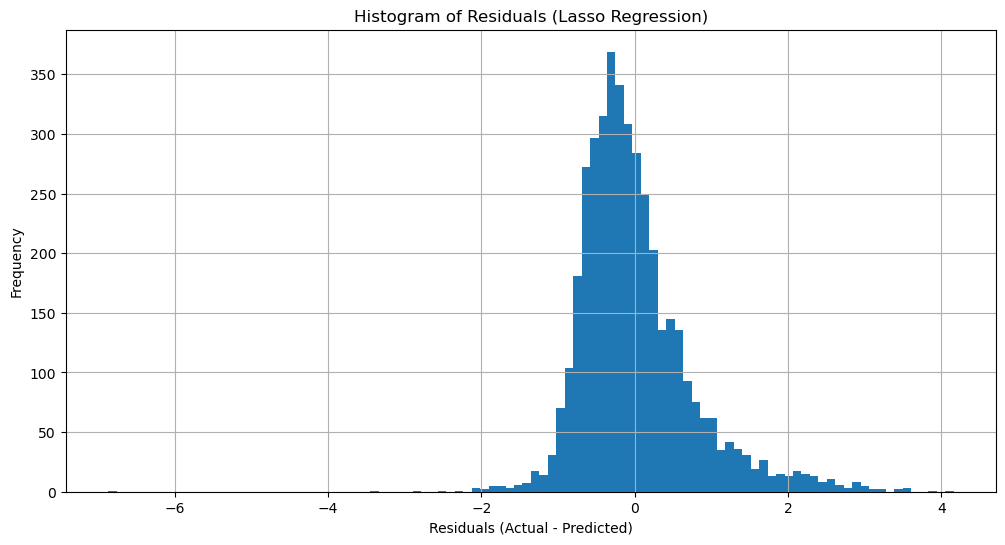

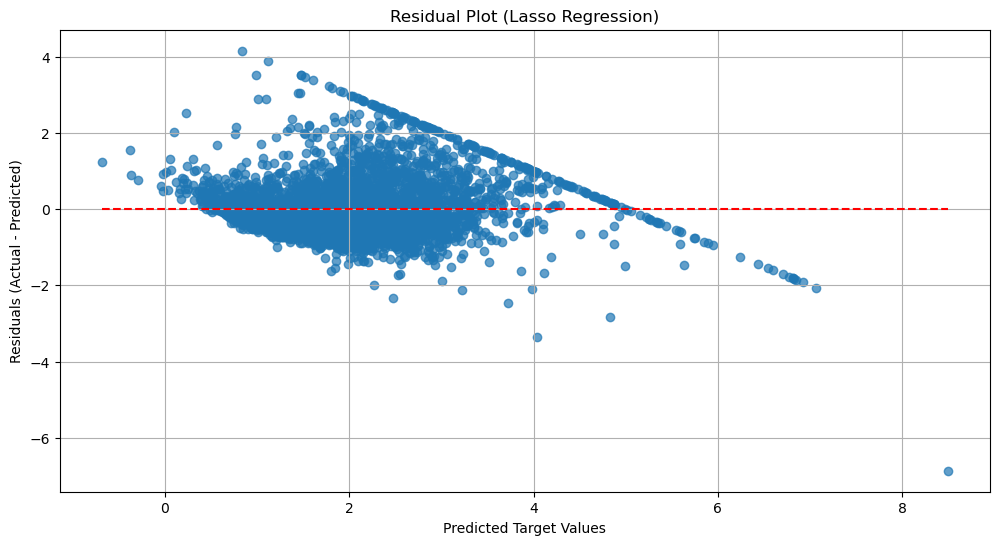

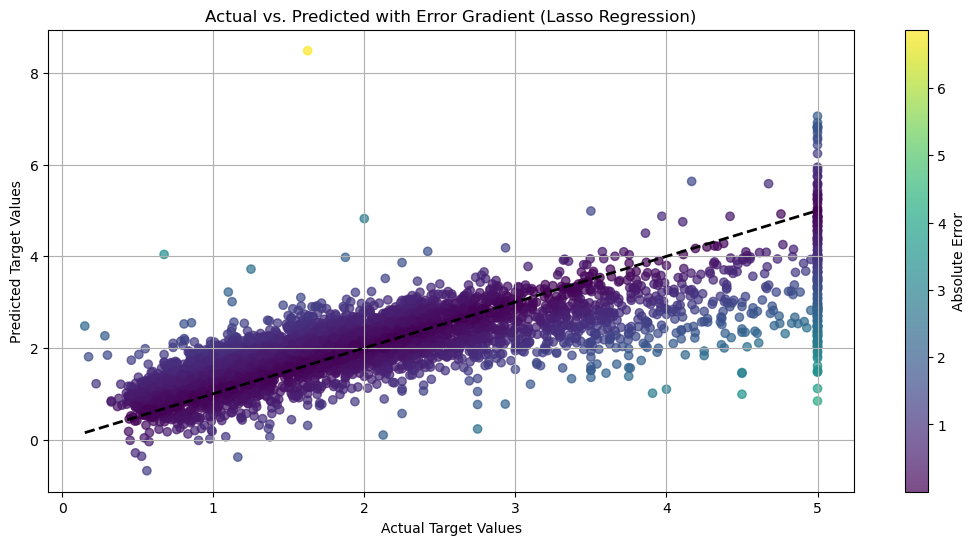

In [93]:
lasso_residuals = y_test - lasso_y_test_prediction

plt.figure(figsize = (12, 6))
plt.hist(lasso_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Lasso Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(lasso_y_test_prediction, lasso_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = lasso_y_test_prediction.min(), xmax = lasso_y_test_prediction.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Lasso Regression)')
plt.grid(True)
plt.show()

errors = abs(y_test - lasso_y_test_prediction) 
plt.figure(figsize = (13, 6))
plt.scatter(y_test, lasso_y_test_prediction, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Lasso Regression)')
plt.grid(True)
plt.show()

#### **Ridge Model**

In [94]:
ridge_y_train_prediction = results["Ridge"]["y_train_prediction"]
ridge_y_test_prediction = results["Ridge"]["y_test_prediction"]

ridge_train_mse = results["Ridge"]["train_mse"]
ridge_test_mse = results["Ridge"]["test_mse"]
ridge_test_mae = results["Ridge"]["test_mae"]
ridge_test_r2 = results["Ridge"]["test_r2"]
ridge_test_adjusted_r2 = results["Ridge"]["test_adjusted_r2"]

ridge_intercept = results["Ridge"]["intercept"]
ridge_coefficients = results["Ridge"]["coefficients"]

In [95]:

ridge_equation = create_fit_function_equation_markdown(ridge_intercept, ridge_coefficients)

ridge_train_mse_string = f"{train_mse_string}: {ridge_train_mse}"
ridge_mse_string = f"{mse_string}: {ridge_test_mse}"
ridge_mae_string = f"{mae_string}: {ridge_test_mae}"
ridge_r2_string = f"{r2_string}: {ridge_test_r2}"
ridge_adjusted_r2_string = f"{adjusted_r2_string}: {ridge_test_adjusted_r2}"


ridge_best_hyperparameters = results["Ridge"]["best_params"]
print(f"Best Hyperparameter Combination: {ridge_best_hyperparameters}")
print()
print("Model Equation:")
print(ridge_equation)
print()
print(ridge_train_mse_string)
print(ridge_mse_string)
print(ridge_mae_string)
print(ridge_r2_string)
print(ridge_adjusted_r2_string)
print()
print(results["Ridge"]["best_params"])

Model Equation:
MedHouseVal = 2.07195 + 0.85421(MedInc) + 0.12278(HouseAge) + -0.29380(AveRooms) + 0.33850(AveBedrms) + -0.00223(Population) + -0.04084(AveOccup) + -0.89462(Latitude) + -0.86750(Longitude)

Mean Squared Error on Training Set: 0.517933981607963
Mean Squared Error on Testing Set: 0.5557806546818751
Mean Absolute Error on Testing Set: 0.5331799929566277
R-Squared Score on Testing Set: 0.5758723696872421
Adjusted R-Squared Score on Testing Set: 0.5750486209515048


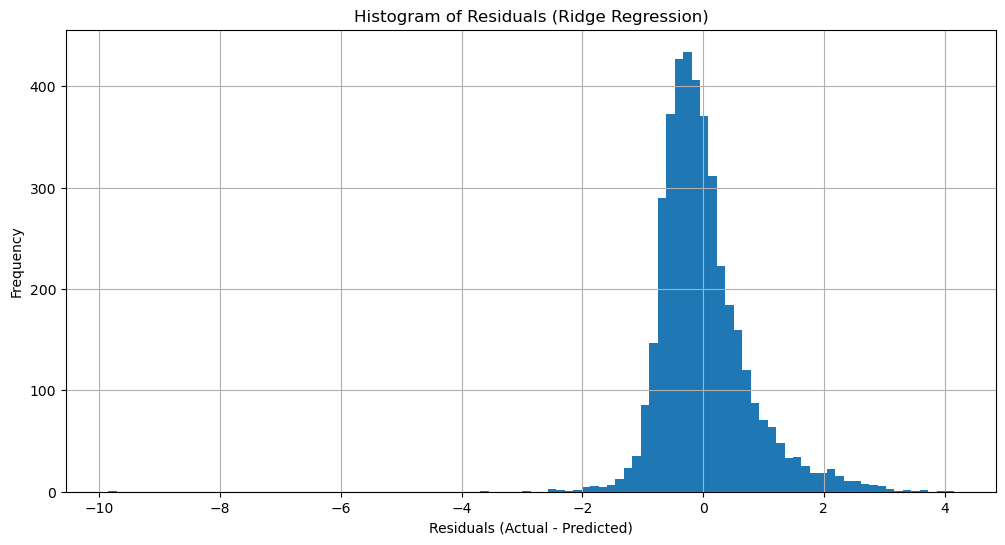

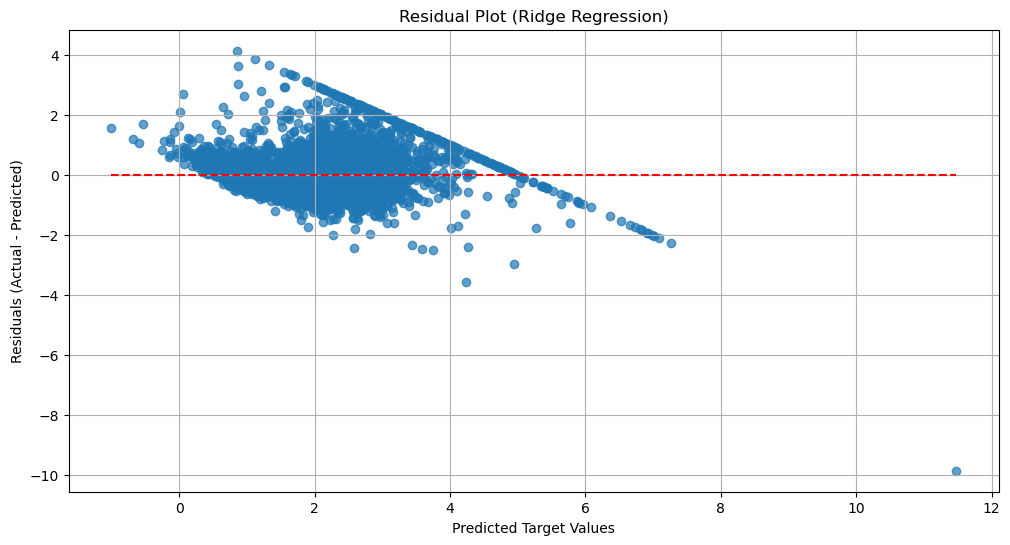

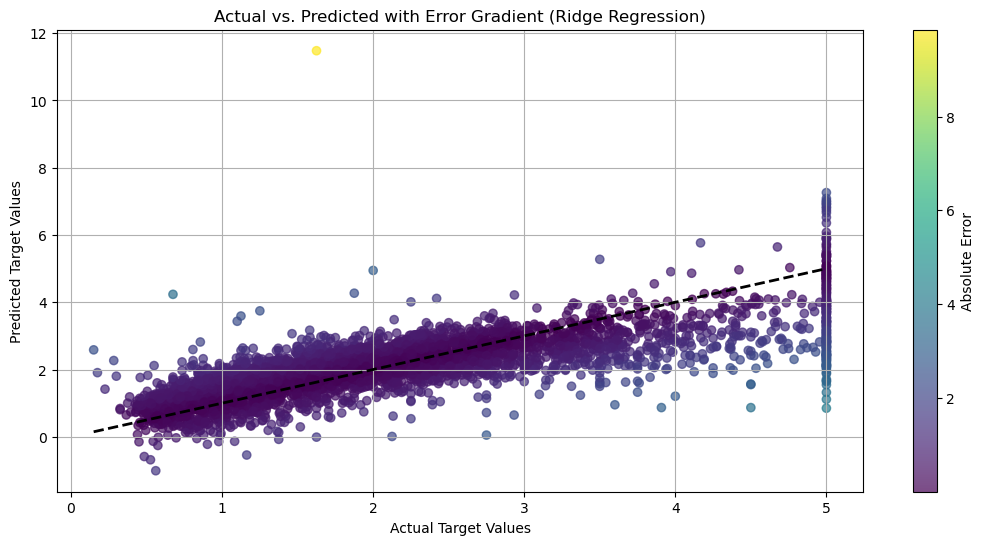

In [96]:
ridge_residuals = y_test - ridge_y_test_prediction

plt.figure(figsize = (12, 6))
plt.hist(ridge_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Ridge Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(ridge_y_test_prediction, ridge_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = ridge_y_test_prediction.min(), xmax = ridge_y_test_prediction.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Ridge Regression)')
plt.grid(True)
plt.show()

errors = abs(y_test - ridge_y_test_prediction) 
plt.figure(figsize = (13, 6))
plt.scatter(y_test, ridge_y_test_prediction, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Ridge Regression)')
plt.grid(True)
plt.show()

#### **Random Forest Model**

In [97]:
random_forest_y_train_prediction = results["Random Forest"]["y_train_prediction"]
random_forest_y_test_prediction = results["Random Forest"]["y_test_prediction"]

random_forest_train_mse = results["Random Forest"]["train_mse"]
random_forest_test_mse = results["Random Forest"]["test_mse"]
random_forest_test_mae = results["Random Forest"]["test_mae"]
random_forest_test_r2 = results["Random Forest"]["test_r2"]
random_forest_test_adjusted_r2 = results["Random Forest"]["test_adjusted_r2"]

In [98]:
random_forest_train_mse_string = f"{train_mse_string}: {random_forest_train_mse}"
random_forest_mse_string = f"{mse_string}: {random_forest_test_mse}"
random_forest_mae_string = f"{mae_string}: {random_forest_test_mae}"
random_forest_r2_string = f"{r2_string}: {random_forest_test_r2}"
random_forest_adjusted_r2_string = f"{adjusted_r2_string}: {random_forest_test_adjusted_r2}"

random_forest_best_hyperparameters = results["Random Forest"]["best_params"]
print(f"Best Hyperparameter Combination: {random_forest_best_hyperparameters}")
print()
print(random_forest_train_mse_string)
print(random_forest_mse_string)
print(random_forest_mae_string)
print(random_forest_r2_string)
print(random_forest_adjusted_r2_string)
print()
print(results["Random Forest"]["best_params"])

Mean Squared Error on Training Set: 0.03302592906030181
Mean Squared Error on Testing Set: 0.245517583769199
Mean Absolute Error on Testing Set: 0.3281187933866282
R-Squared Score on Testing Set: 0.8126404902240649
Adjusted R-Squared Score on Testing Set: 0.8122765970271221

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


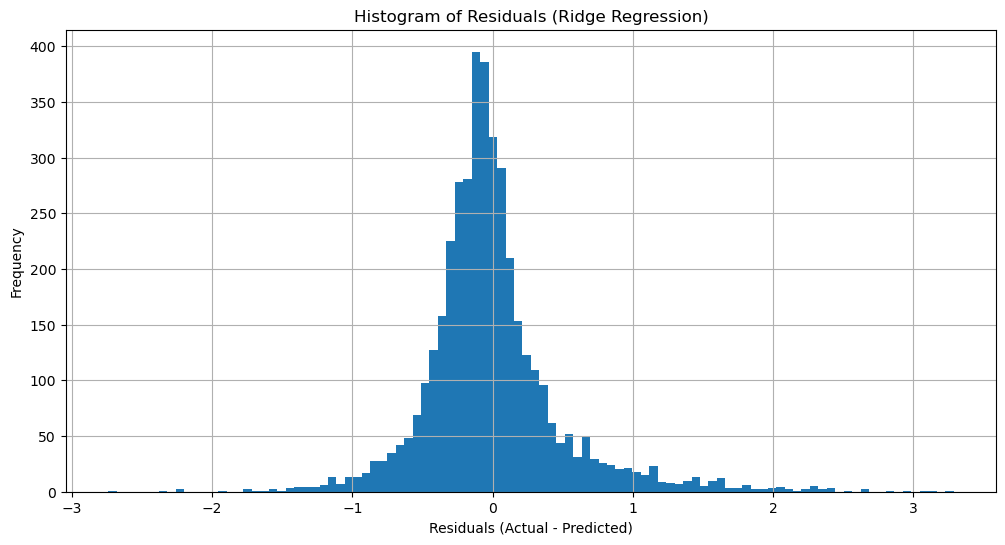

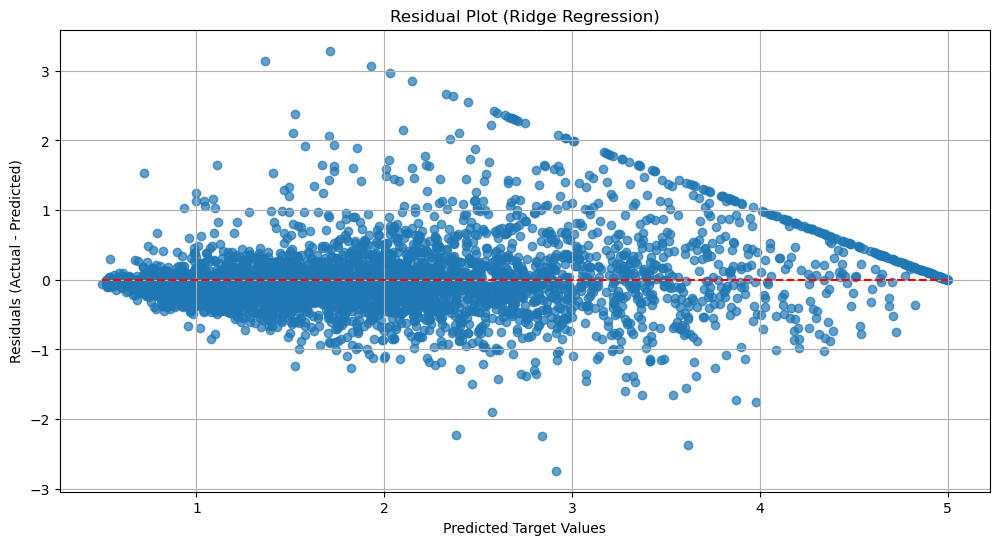

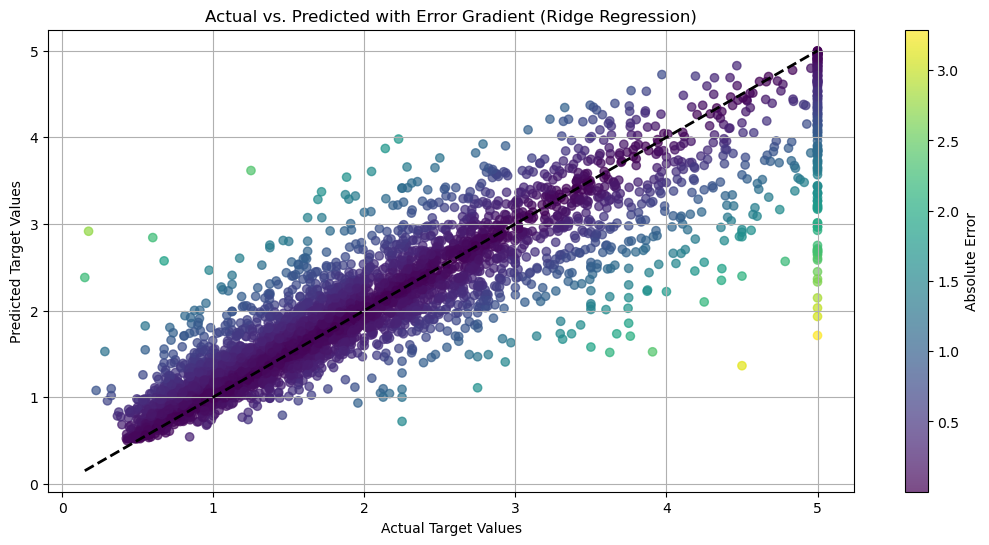

In [99]:
ridge_residuals = y_test - random_forest_y_test_prediction

plt.figure(figsize = (12, 6))
plt.hist(ridge_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Ridge Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(random_forest_y_test_prediction, ridge_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = random_forest_y_test_prediction.min(), xmax = random_forest_y_test_prediction.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Ridge Regression)')
plt.grid(True)
plt.show()

errors = abs(y_test - random_forest_y_test_prediction) 
plt.figure(figsize = (13, 6))
plt.scatter(y_test, random_forest_y_test_prediction, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Ridge Regression)')
plt.grid(True)
plt.show()

#### **Support Vector Model**

In [100]:
svr_best_hyperparameters = results["SVR"]["best_params"]

svr_y_train_prediction = results["SVR"]["y_train_prediction"]
svr_y_test_prediction = results["SVR"]["y_test_prediction"]

svr_train_mse = results["SVR"]["train_mse"]
svr_test_mse = results["SVR"]["test_mse"]
svr_test_mae = results["SVR"]["test_mae"]
svr_test_r2 = results["SVR"]["test_r2"]
svr_test_adjusted_r2 = results["SVR"]["test_adjusted_r2"]

In [104]:
svr_train_mse_string = f"{train_mse_string}: {svr_train_mse}"
svr_mse_string = f"{mse_string}: {svr_test_mse}"
svr_mae_string = f"{mae_string}: {svr_test_mae}"
svr_r2_string = f"{r2_string}: {svr_test_r2}"
svr_adjusted_r2_string = f"{adjusted_r2_string}: {svr_test_adjusted_r2}"

print(f"Best Hyperparameter Combination: {svr_best_hyperparameters}")
print()
print(svr_train_mse_string)
print(svr_mse_string)
print(svr_mae_string)
print(svr_r2_string)
print(svr_adjusted_r2_string)

Mean Squared Error on Training Set: 0.29502691985997936
Mean Squared Error on Testing Set: 0.32371600919819826
Mean Absolute Error on Testing Set: 0.3774484750302886
R-Squared Score on Testing Set: 0.7529656660069923
Adjusted R-Squared Score on Testing Set: 0.7524858712335172

{'svr__C': 10}


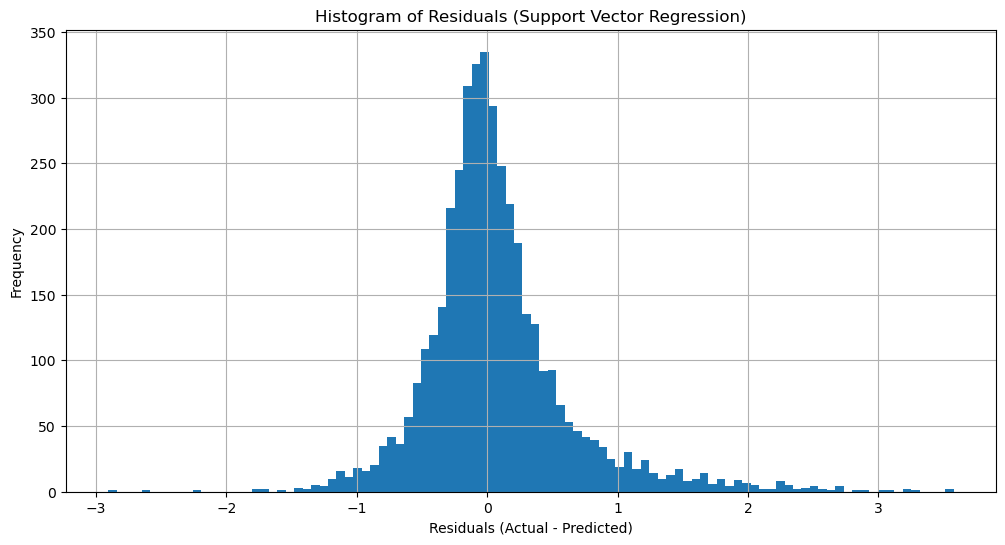

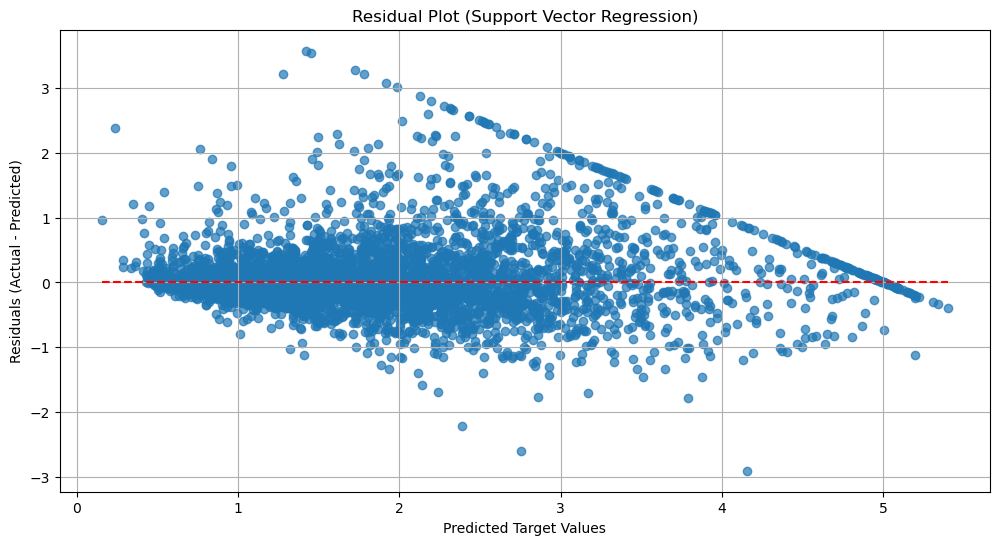

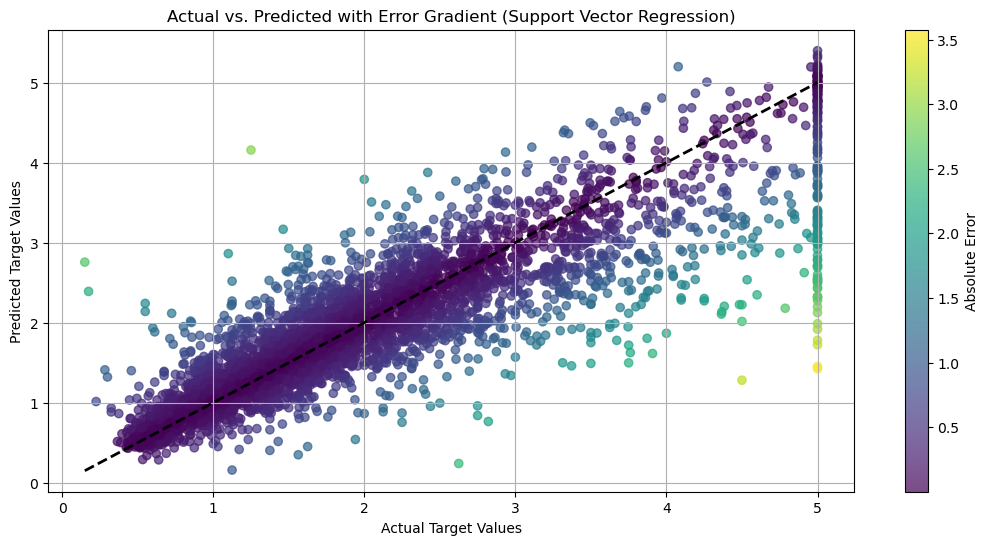

In [102]:
svr_residuals = y_test - svr_y_test_prediction

plt.figure(figsize = (12, 6))
plt.hist(svr_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Support Vector Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(svr_y_test_prediction, svr_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = svr_y_test_prediction.min(), xmax = svr_y_test_prediction.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Support Vector Regression)')
plt.grid(True)
plt.show()

errors = abs(y_test - svr_y_test_prediction) 
plt.figure(figsize = (13, 6))
plt.scatter(y_test, svr_y_test_prediction, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Support Vector Regression)')
plt.grid(True)
plt.show()

## **Model Comparison**

In [103]:
df_columns = ['Model', 'MSE on Training Set', 'MSE', 'MAE', 'R-squared', 'Adjusted R-squared']

results_df = pd.DataFrame(result_df_data, columns = df_columns)
results_df

,Model,MSE on Training Set,MSE,MAE,R-squared,Adjusted R-squared
0,Linear,0.517933,0.555892,0.533200,0.575788,0.574964
1,Lasso,0.523384,0.548255,0.535326,0.581615,0.580803
2,Ridge,0.517934,0.555781,0.533180,0.575872,0.575049
3,Random Forest,0.033026,0.245518,0.328119,0.812640,0.812277
4,SVR,0.295027,0.323716,0.377448,0.752966,0.752486


In [63]:
best_model = results_df.loc[results_df['R-squared'].idxmax(), 'Model']

print(f"Reccomended Model based on R-squared Score (higher is better): {best_model}")


Reccomended Model based on R-squared Score (higher is better): Random Forest
